##### **Importing Libraries**

In [ ]:
import os
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
warnings.filterwarnings("ignore")


##### **Downloading dataset and extraction**

In [ ]:
import os
import subprocess
from zipfile import ZipFile

def fetch_aptos2019(save_dir="/content/aptos2019", zip_name="aptos2019.zip"):
    os.makedirs(save_dir, exist_ok=True)
    zip_file = os.path.join(save_dir, zip_name)

    subprocess.run([
        "curl", "-L", "-o", zip_file,
        "https://www.kaggle.com/api/v1/datasets/download/mariaherrerot/aptos2019"
    ], check=True)

    with ZipFile(zip_file, "r") as z:
        z.extractall(os.path.join(save_dir, "dataset"))

    print("Downloaded and extracted at:", os.path.join(save_dir, "dataset"))

fetch_aptos2019()


Downloaded and extracted at: /content/aptos2019/dataset


###### **Loading CSV files**

In [ ]:
train_data = pd.read_csv("/content/aptos2019/dataset/train_1.csv")
valid_data = pd.read_csv("/content/aptos2019/dataset/valid.csv")
test_data = pd.read_csv("/content/aptos2019/dataset/test.csv")

print(train_data.shape, valid_data.shape, test_data.shape)


(2930, 2) (366, 2) (366, 2)


##### **Directory Checks**

In [ ]:
train_image_dir = "/content/aptos2019/dataset/train_images/train_images"
val_image_dir = "/content/aptos2019/dataset/val_images/val_images"
test_image_dir = "/content/aptos2019/dataset/test_images/test_images"

def count_images(path):
    return len([i for i in os.listdir(path) if i.endswith(('.png','.jpg','.jpeg'))])

print(count_images(train_image_dir), count_images(val_image_dir), count_images(test_image_dir))


2930 366 366


##### **Sample Images**

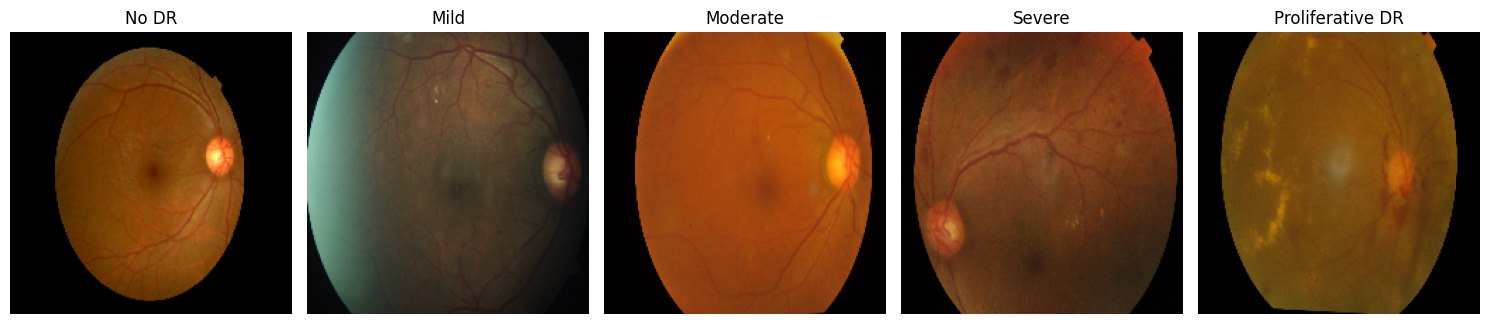

In [ ]:
labels = {0:"No DR",1:"Mild",2:"Moderate",3:"Severe",4:"Proliferative DR"}

unique_ids = []
for c in range(5):
    img_id = train_data[train_data['diagnosis'] == c]['id_code'].iloc[0]
    unique_ids.append((img_id, c))

plt.figure(figsize=(15, 4))
for i, (img_id, c) in enumerate(unique_ids):
    img = load_img(os.path.join(train_image_dir, f"{img_id}.png"), target_size=(200,200))
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(labels[c], fontsize=12)

plt.tight_layout()
plt.show()


##### **Class Distribution**

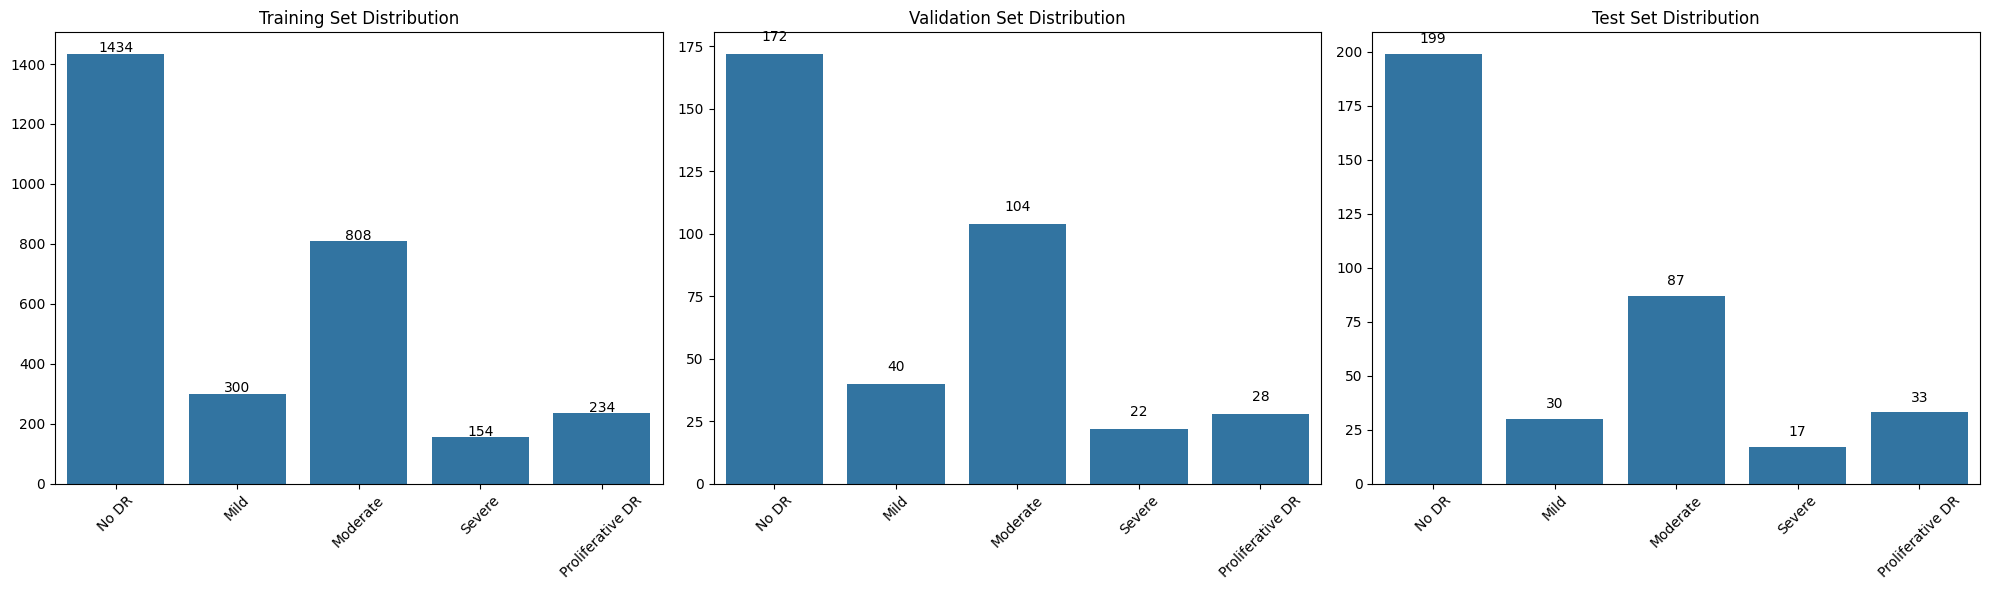

In [ ]:
label_map = {0:"No DR",1:"Mild",2:"Moderate",3:"Severe",4:"Proliferative DR"}

train_counts = train_data['diagnosis'].value_counts().sort_index()
val_counts = valid_data['diagnosis'].value_counts().sort_index()
test_counts = test_data['diagnosis'].value_counts().sort_index()

train_labels = [label_map[i] for i in train_counts.index]
val_labels   = [label_map[i] for i in val_counts.index]
test_labels  = [label_map[i] for i in test_counts.index]

plt.figure(figsize=(20,6))

plt.subplot(1,3,1)
ax = sns.barplot(x=train_labels, y=train_counts.values)
for i, v in enumerate(train_counts.values):
    ax.text(i, v + 5, str(v), ha='center')
plt.title("Training Set Distribution")
plt.xticks(rotation=45)

plt.subplot(1,3,2)
ax = sns.barplot(x=val_labels, y=val_counts.values)
for i, v in enumerate(val_counts.values):
    ax.text(i, v + 5, str(v), ha='center')
plt.title("Validation Set Distribution")
plt.xticks(rotation=45)

plt.subplot(1,3,3)
ax = sns.barplot(x=test_labels, y=test_counts.values)
for i, v in enumerate(test_counts.values):
    ax.text(i, v + 5, str(v), ha='center')
plt.title("Test Set Distribution")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


##### **Dimension Distributions**

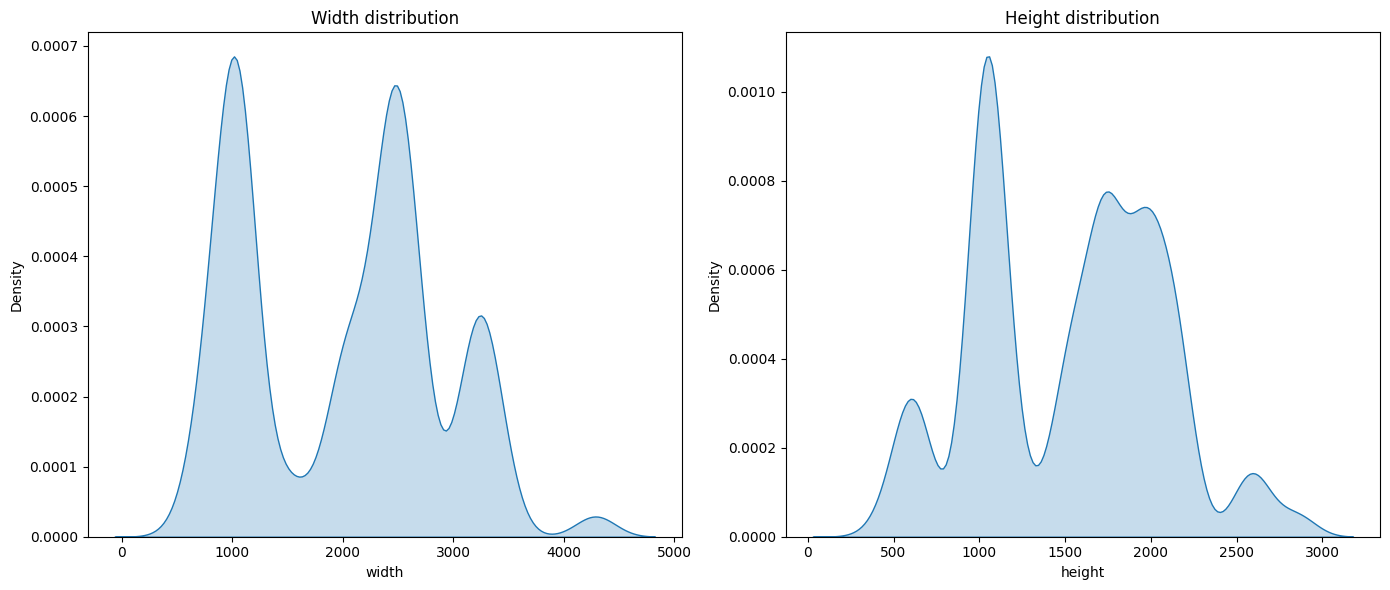

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

sizes = []

for img_id in train_data['id_code']:
    path = os.path.join(train_image_dir, f"{img_id}.png")
    if os.path.exists(path):
        w, h = Image.open(path).size
        sizes.append([img_id, w, h])

df_dims = pd.DataFrame(sizes, columns=["id_code", "width", "height"])
df_dims.head()

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.kdeplot(df_dims['width'], fill=True)
plt.title("Width distribution")

plt.subplot(1,2,2)
sns.kdeplot(df_dims['height'], fill=True)
plt.title("Height distribution")

plt.tight_layout()
plt.show()


**Preprocessing + (Data Upsampling) SMOTE**

In [ ]:
IMG_SIZE = 100

def preprocess(idc):
    img = load_img(os.path.join(train_image_dir, f"{idc}.png"), target_size=(IMG_SIZE,IMG_SIZE))
    return img_to_array(img)/255.0

X = np.array([preprocess(i) for i in train_data['id_code']])
y = train_data['diagnosis'].values

sm = SMOTE(random_state=42)
Xr, yr = sm.fit_resample(X.reshape(X.shape[0], -1), y)
Xr = Xr.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
yr = to_categorical(yr, num_classes=5)

X_train, X_val, y_train, y_val = train_test_split(Xr, yr, test_size=0.2, random_state=42)


##### **Data distribution after upsampling**

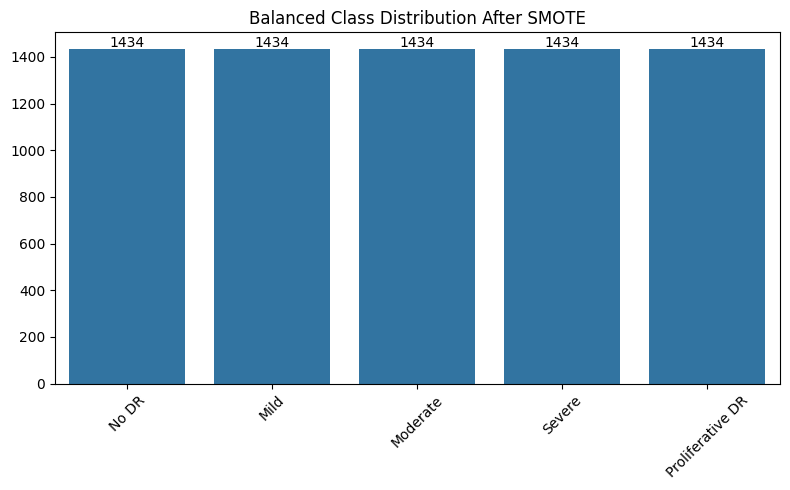

In [ ]:
yr_classes = np.argmax(yr, axis=1)
yr_counts = pd.Series(yr_classes).value_counts().sort_index()

labels = {0:"No DR",1:"Mild",2:"Moderate",3:"Severe",4:"Proliferative DR"}
yr_labels = [labels[i] for i in yr_counts.index]

plt.figure(figsize=(8,5))
ax = sns.barplot(x=yr_labels, y=yr_counts.values)
for i,v in enumerate(yr_counts.values):
    ax.text(i, v + 10, str(v), ha='center')
plt.title("Balanced Class Distribution After SMOTE")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
